In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import host_subplot
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Data

In [2]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2022, 6, 25)

In [3]:
df = yf.download('AAPL', start = start, end = end)[['Close']]
df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
...,...
2022-06-17,131.559998
2022-06-21,135.869995
2022-06-22,135.350006


# Price Regression

We will regress prices for a measure of the momentum of the stock. A future project could entail performing the regression on the daily returns of the stock.

When I did this project in Excel, I used the LINEST function to do the regression. So, this project will also be using the Least Squares method. Sklearn's Linear Regression uses Scipy's lstsq method, so the result is the same.

The regression function will include the regression coefficient, the regression intercept and the r squared value of accuracy. These have been included for exploration of results. Future projects on more equities will only include the coefficients.

In [4]:
def regressorizer(y):
    x = np.asarray(np.matrix([i for i in range(y.shape[0])])).T
    reg = LinearRegression().fit(x,y)
    score = reg.score(x,y)
    return float(reg.coef_.round(3)), reg.intercept_.round(3), round(score,3)

In [5]:
%%time
df1 = df.resample('W-MON',label = 'left', closed = 'left').apply(lambda x: regressorizer(x))
df1

CPU times: total: 516 ms
Wall time: 525 ms


,Close
Date,
2010-01-04,"(-0.028, 7.641, 0.513)"
2010-01-11,"(-0.024, 7.504, 0.296)"
2010-01-18,"(-0.198, 7.731, 0.915)"
2010-01-25,"(-0.102, 7.407, 0.524)"
2010-02-01,"(-0.008, 6.998, 0.021)"
...,...
2022-05-23,"(1.648, 140.186, 0.479)"
2022-05-30,"(-0.788, 149.717, 0.18)"
2022-06-06,"(-2.409, 149.334, 0.644)"


## Regression Plot

Let's see our line of best fit for an arbitrary week.

In [6]:
start1 = dt.datetime(2022, 6, 6)
end1 = dt.datetime(2022,6,12)

In [7]:
aapl2022 = df[start1:end1]
aapl2022

,Close
Date,
2022-06-06,146.139999
2022-06-07,148.710007
2022-06-08,147.960007
2022-06-09,142.639999
2022-06-10,137.130005


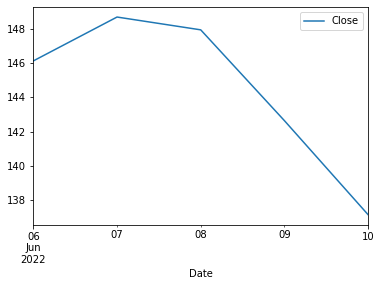

In [8]:
aapl2022.plot();

In [9]:
regress = df1.loc['2022-06-06']
regress

Close    (-2.409, 149.334, 0.644)
Name: 2022-06-06 00:00:00, dtype: object

In [10]:
x = aapl2022.index
t = [regress[0][0] * i + regress[0][1] for i in range(len(x))]
aapl2022.insert(len(aapl2022.columns),'Trend',t)

In [11]:
aapl2022

,Close,Trend
Date,,
2022-06-06,146.139999,149.334
2022-06-07,148.710007,146.925
2022-06-08,147.960007,144.516
2022-06-09,142.639999,142.107
2022-06-10,137.130005,139.698


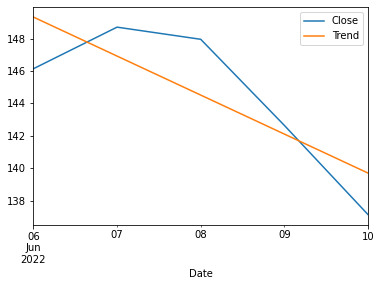

In [12]:
ax = aapl2022.plot(y='Close')
aapl2022.plot.line(y='Trend',ax = ax);

## Coefficient Plot

Can we see any trends in the regression coefficients over time?

In [13]:
coeff = pd.DataFrame({'AAPL Coeff':[i[0] for i in df1.Close]}, index = df1.index)
coeff

,AAPL Coeff
Date,
2010-01-04,-0.028
2010-01-11,-0.024
2010-01-18,-0.198
2010-01-25,-0.102
2010-02-01,-0.008
...,...
2022-05-23,1.648
2022-05-30,-0.788
2022-06-06,-2.409


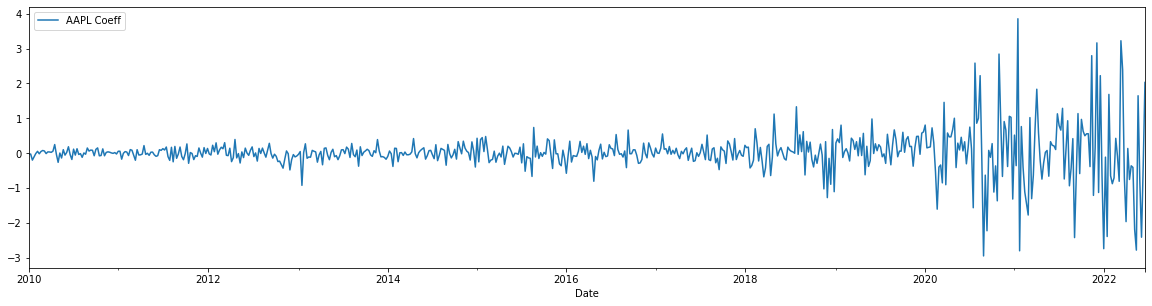

In [14]:
coeff.plot(figsize = (20,4.8));
plt.legend(loc='upper left')
plt.show()

In fact, we can see a trend. The regression coefficients have been going up over time, with the numbers exploding in 2020. This is related to elevated share price. An equity with a higher share price will have a larger regression coefficient than one with a smaller share price if both equities move by the same percent over time.

## $R^{2}$ over time

How about model accuarcy over time? Can we see any trends over time there?

In [15]:
r2 = pd.DataFrame({'AAPL R^2':[i[2] for i in df1.Close]}, index = df1.index)
r2

,AAPL R^2
Date,
2010-01-04,0.513
2010-01-11,0.296
2010-01-18,0.915
2010-01-25,0.524
2010-02-01,0.021
...,...
2022-05-23,0.479
2022-05-30,0.180
2022-06-06,0.644


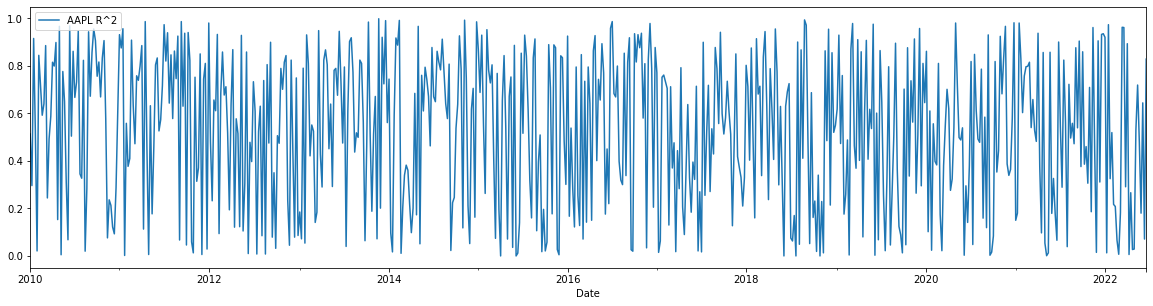

In [16]:
r2.plot(figsize = (20,4.8));
plt.legend(loc='upper left')
plt.show()

As it turns out, no. This doesn't really tell us much. Oh well.

## Standard Deviation over time

Now we will look at standard deviation of the daily return of the stock over time

In [17]:
df_pct = df.pct_change()
df_pct

,Close
Date,
2010-01-04,NaN
2010-01-05,0.001729
2010-01-06,-0.015906
2010-01-07,-0.001849
2010-01-08,0.006648
...,...
2022-06-17,0.011533
2022-06-21,0.032761
2022-06-22,-0.003827


In [18]:
df_pct_std = pd.DataFrame({'Std Dev':[df_pct.Close[0:i].std() for i in range(len(df_pct.Close))]}, index = df_pct.index)
df_pct_std

,Std Dev
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,0.012470
2010-01-08,0.009322
...,...
2022-06-17,0.017897
2022-06-21,0.017895
2022-06-22,0.017902


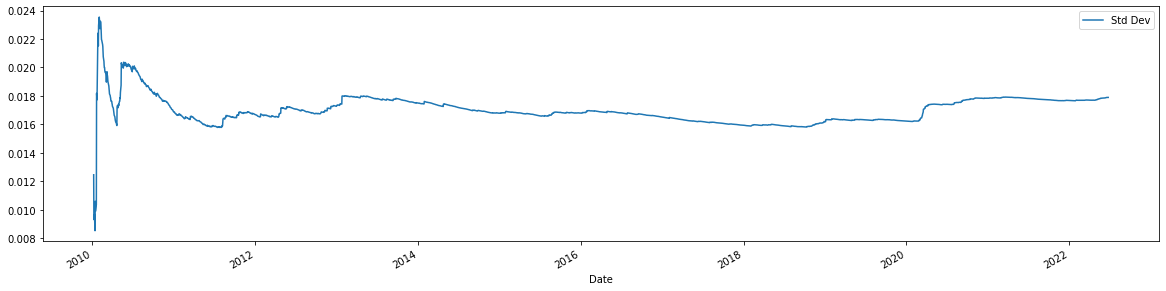

In [19]:
df_pct_std.plot(figsize = (20,4.8));

# Percent Change Regression

In [20]:
df_pct = df_pct.dropna()
df_pct

,Close
Date,
2010-01-05,0.001729
2010-01-06,-0.015906
2010-01-07,-0.001849
2010-01-08,0.006648
2010-01-11,-0.008821
...,...
2022-06-17,0.011533
2022-06-21,0.032761
2022-06-22,-0.003827


In [21]:
df2 = df_pct.resample('W-MON',label = 'left', closed = 'left').apply(lambda x: regressorizer(x))
df2

,Close
Date,
2010-01-04,"(0.003, -0.007, 0.147)"
2010-01-11,"(-0.001, -0.004, 0.019)"
2010-01-18,"(-0.028, 0.033, 0.875)"
2010-01-25,"(-0.018, 0.031, 0.85)"
2010-02-01,"(-0.003, 0.011, 0.056)"
...,...
2022-05-23,"(0.004, 0.008, 0.071)"
2022-05-30,"(-0.008, 0.005, 0.209)"
2022-06-06,"(-0.014, 0.017, 0.798)"


## Coefficient Plot

In [22]:
pct_coeff = pd.DataFrame({'AAPL Coeff':[i[0] for i in df2.Close]}, index = df2.index)
pct_coeff

,AAPL Coeff
Date,
2010-01-04,0.003
2010-01-11,-0.001
2010-01-18,-0.028
2010-01-25,-0.018
2010-02-01,-0.003
...,...
2022-05-23,0.004
2022-05-30,-0.008
2022-06-06,-0.014


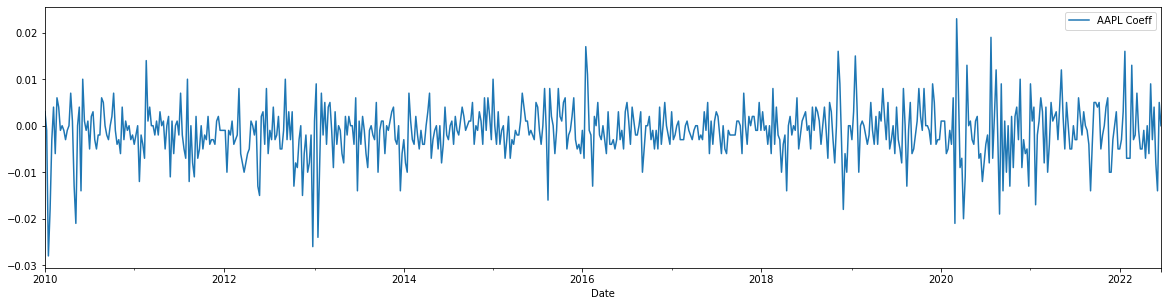

In [23]:
pct_coeff.plot(figsize = (20,4.8));

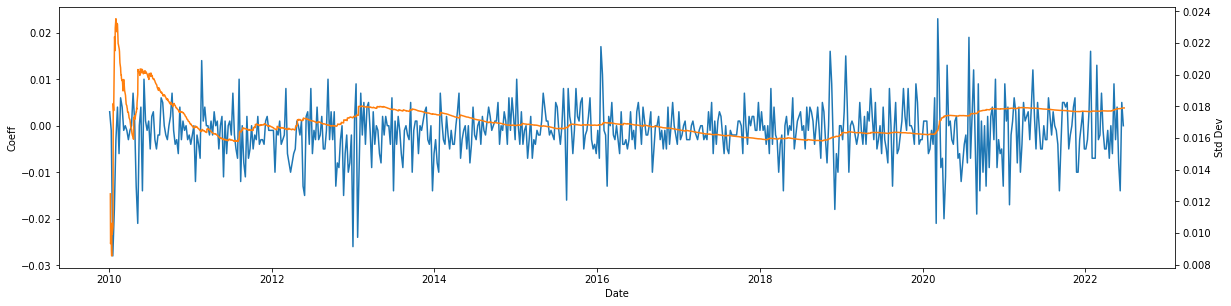

In [24]:
figure(figsize = [20,4.8])

host = host_subplot(111)

par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("Coeff")
par.set_ylabel("Std Dev")

p1, = host.plot(pct_coeff)
p2, = par.plot(df_pct_std)

plt.show()

We can see that standard deviation seems to rise when coefficients deviate from zero, particularly at the beginning of 2020. However, this does not seem to be a very strong relationship.

In [25]:
pct_coeff_std = pct_coeff.join(df_pct_std)
pct_coeff_std

,AAPL Coeff,Std Dev
Date,,
2010-01-04,0.003,NaN
2010-01-11,-0.001,0.009689
2010-01-18,-0.028,NaN
2010-01-25,-0.018,0.021469
2010-02-01,-0.003,0.023540
...,...,...
2022-05-23,0.004,0.017835
2022-05-30,-0.008,NaN
2022-06-06,-0.014,0.017862


In [26]:
pct_coeff_std.corr()

,AAPL Coeff,Std Dev
AAPL Coeff,1.000000,-0.021717
Std Dev,-0.021717,1.000000


So we see that the correlation between the coefficients and the standard deviation is very small.

## $R^{2}$ over time

In [27]:
r2_pct = pd.DataFrame({'AAPL R^2':[i[2] for i in df2.Close]}, index = df2.index)
r2

,AAPL R^2
Date,
2010-01-04,0.513
2010-01-11,0.296
2010-01-18,0.915
2010-01-25,0.524
2010-02-01,0.021
...,...
2022-05-23,0.479
2022-05-30,0.180
2022-06-06,0.644


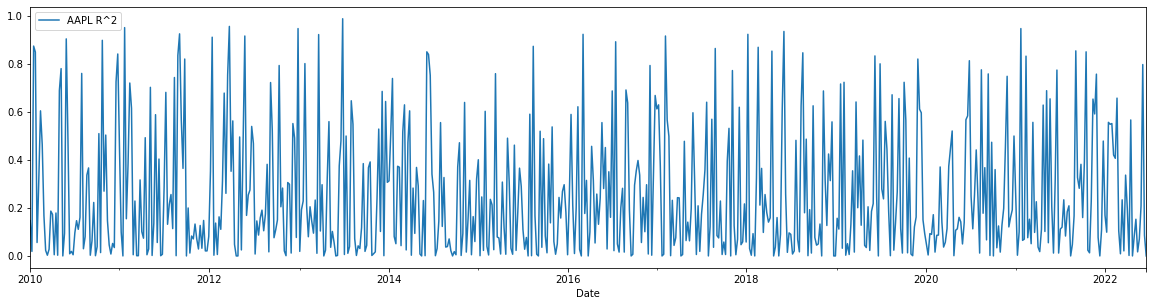

In [28]:
r2_pct.plot(figsize = (20,4.8));
plt.legend(loc='upper left')
plt.show()

In [29]:
r2_pct.mean()

AAPL R^2    0.256616
dtype: float64

In [30]:
r2_pct.median()

AAPL R^2    0.16
dtype: float64